In [150]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Importing the dataset
df = pd.read_csv('/kaggle/input/twitter-emoji-prediction/Train.csv')
df2 = pd.read_csv('/kaggle/input/twitter-emoji-prediction/Mapping.csv')

In [151]:
df2[["Label"]] = df2[["number"]]
df2.drop("number", axis = 1, inplace=True)
df = pd.merge(df, df2, on='Label', how='left')
df.head()

,Unnamed: 0_x,TEXT,Label,Unnamed: 0_y,emoticons
0,0,Vacation wasted ! #vacation2017 #photobomb #ti...,0,0,😜
1,1,"Oh Wynwood, you’re so funny! : @user #Wynwood ...",1,1,📸
2,2,Been friends since 7th grade. Look at us now w...,2,2,😍
3,3,This is what it looks like when someone loves ...,3,3,😂
4,4,RT @user this white family was invited to a Bl...,3,3,😂


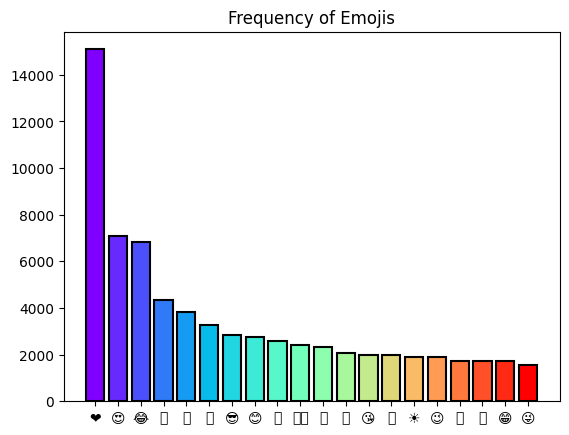

In [152]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
#plt.rcParams['font.family'] = 'DejaVu Sans'
emoji_counts = df["emoticons"].value_counts()
colors = plt.cm.rainbow(np.linspace(0, 1, len(emoji_counts)))
plt.bar(
    emoji_counts.index,
    emoji_counts.values,
    color=colors,
    edgecolor='black',
    linewidth=1.5
)
# Customizing the plot
plt.title("Frequency of Emojis")
plt.grid(False)  # Optionally turn off grid


In [93]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import os

# Set a specific download directory (Kaggle typically has /root/nltk_data as a default)
nltk_data_dir = '/root/nltk_data'
os.makedirs(nltk_data_dir, exist_ok=True)

# Append the NLTK data directory to the search path
nltk.data.path.append(nltk_data_dir)

# Download the resources
nltk.download('wordnet', download_dir=nltk_data_dir)
nltk.download('stopwords', download_dir=nltk_data_dir)
nltk.download('omw-1.4', download_dir=nltk_data_dir)
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
replace /usr/share/nltk_data/corpora/wordnet/lexnames? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [135]:
def preprocess_text(text):
    # lower text
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove mentions and hashtags
    text = re.sub(r'@\w+|#', '', text)
    # Remove special characters
    text = re.sub(r'[^a-z\s]', '', text)

    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    clean_text = ' '.join(tokens)
    return clean_text

In [153]:
df['cleaned_text'] = df['TEXT'].apply(preprocess_text)

In [154]:
df["TEXT"].apply(len).max()

168

In [155]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['cleaned_text'])
sequences = tokenizer.texts_to_sequences(df['cleaned_text'])

max_length = 50
X = pad_sequences(sequences, maxlen=max_length)
y = df['Label'].values


In [156]:
pd.Series(df['Label'].values).unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [157]:
from gensim.models import Word2Vec

# Tokenize the cleaned text for Word2Vec training
sentences = [text.split() for text in df['cleaned_text'].values]

# Train the Word2Vec model
word2vec_model = Word2Vec(sentences, vector_size=300, window=5, min_count=1, workers=4)

# Save the model (optional)
word2vec_model.save("word2vec.model")

vocab_size = len(tokenizer.word_index) + 1  # Add 1 for padding index
embedding_dim = 300  # The same as Word2Vec vector size
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, index in tokenizer.word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[index] = word2vec_model.wv[word]
    else:
        # Random initialization for words not in Word2Vec
        embedding_matrix[index] = np.random.randn(embedding_dim)

In [158]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weights_dict = dict(zip(np.unique(y), class_weights))

sample_weights = np.array([class_weights_dict[label] for label in y])


X_train, X_test, y_train, y_test, sample_weights_train, sample_weights_test = train_test_split(
    X, y, sample_weights, test_size=0.15, random_state=42, stratify=y
)


In [159]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
checkpoint_callback = ModelCheckpoint(
    filepath='/kaggle/working/texttoemoji_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=0
)


from tensorflow.keras.callbacks import ReduceLROnPlateau


reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss',  
    factor=0.1,          
    patience=6,          
    min_lr=1e-5,         
    verbose=1            
)


In [160]:
X_train.shape

(59500, 50)

In [161]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization, Bidirectional, MultiHeadAttention, Flatten,Input

In [164]:
input_layer = Input(shape=(max_length,), name='Input_Layer')
embedding_layer = Embedding(input_dim=len(tokenizer.word_index)+1, 
                            output_dim=embedding_dim, 
                            weights=[embedding_matrix], 
                            input_length=max_length, 
                            trainable=True, 
                            name='Embedding_Layer')(input_layer)
bidirectional_lstm = Bidirectional(LSTM(units=64, return_sequences=True), name='Bidirectional_LSTM')(embedding_layer)
batch_norm = BatchNormalization(name='BatchNormalization')(bidirectional_lstm)

dropout_1 = Dropout(0.3, name='Dropout_1')(batch_norm)
multi_head_attention = MultiHeadAttention(num_heads=20, key_dim=embedding_dim, name='MultiHead_Attention')(dropout_1, dropout_1,dropout_1)
flatten = Flatten(name='Flatten')(multi_head_attention)

dense = Dense(units=32, activation='relu', name='Dense_Layer')(flatten)
dropout_3 = Dropout(0.2, name='Dropout_3')(dense)

output_layer = Dense(units=20, activation='softmax', name='Output_Layer')(dropout_3)

model = Model(inputs=input_layer, outputs=output_layer)
model.build(input_shape=(None, max_length)) 

from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_29"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input_Layer         │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Embedding_Layer     │ (None, 50, 300)   │ 21,905,700 │ Input_Layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Bidirectional_LSTM  │ (None, 50, 128)   │    186,880 │ Embedding_Layer[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ BatchNormalization  │ (None, 50, 128)   │        512 │ Bidirectional_LS… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dropout_1 (Dropout) │ (None, 50, 128)   │          0 │ BatchNormalizati… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MultiHead_Attention │ (None, 50, 128)   │  3,090,128 │ Dropout_1[0][0],  │
│ (MultiHeadAttentio… │                   │            │ Dropout_1[0][0],  │
│                     │                   │            │ Dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Flatten (Flatten)   │ (None, 6400)      │          0 │ MultiHead_Attent… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense_Layer (Dense) │ (None, 32)        │    204,832 │ Flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dropout_3 (Dropout) │ (None, 32)        │          0 │ Dense_Layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Output_Layer        │ (None, 20)        │        660 │ Dropout_3[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 25,388,712 (96.85 MB)

 Trainable params: 25,388,456 (96.85 MB)

 Non-trainable params: 256 (1.00 KB)

In [165]:
model.fit(X_train, y_train,
          epochs=50, batch_size=64,
          validation_data=(X_test, y_test),
          sample_weight=sample_weights_train,
          callbacks=[checkpoint_callback,reduce_lr_callback] )

Epoch 1/50
930/930 ━━━━━━━━━━━━━━━━━━━━ 67s 68ms/step - accuracy: 0.1056 - loss: 2.8772 - val_accuracy: 0.1394 - val_loss: 2.7860 - learning_rate: 1.0000e-04
Epoch 2/50
930/930 ━━━━━━━━━━━━━━━━━━━━ 64s 69ms/step - accuracy: 0.1574 - loss: 2.7248 - val_accuracy: 0.1630 - val_loss: 2.6824 - learning_rate: 1.0000e-04
Epoch 3/50
930/930 ━━━━━━━━━━━━━━━━━━━━ 63s 68ms/step - accuracy: 0.1845 - loss: 2.6015 - val_accuracy: 0.1444 - val_loss: 2.7463 - learning_rate: 1.0000e-04
Epoch 4/50
930/930 ━━━━━━━━━━━━━━━━━━━━ 63s 68ms/step - accuracy: 0.1991 - loss: 2.5149 - val_accuracy: 0.1577 - val_loss: 2.8243 - learning_rate: 1.0000e-04
Epoch 5/50
930/930 ━━━━━━━━━━━━━━━━━━━━ 64s 69ms/step - accuracy: 0.2129 - loss: 2.4390 - val_accuracy: 0.1714 - val_loss: 2.6698 - learning_rate: 1.0000e-04
Epoch 6/50
930/930 ━━━━━━━━━━━━━━━━━━━━ 65s 69ms/step - accuracy: 0.2264 - loss: 2.3576 - val_accuracy: 0.1942 - val_loss: 2.6383 - learning_rate: 1.0000e-04
Epoch 7/50
930/930 ━━━━━━━━━━━━━━━━━━━━ 63s 68ms/ste